# Data Preprocessing
1. Import Libraries and download data
2. Scale training and test data using training data parameters to ensure no data leakage
3. Creates Sequences for training
4. Utilise Encoder-Decoder Network to reduce dimensionality of data to reduce overfitting

In [1]:
random_state = 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Layer, Dropout, BatchNormalization, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import AdamW, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MAE

2024-08-26 18:39:24.017166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 18:39:24.017287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 18:39:24.159701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Read dataset and set index to datetime for plotting purposes
data = pd.read_csv("/kaggle/input/eth-all/ETH_return2.csv")
data["timestamp"] = pd.to_datetime(data["timestamp"])
data.set_index("timestamp", inplace=True)


# Scale data using train parameters to ensure no data leakage
split = int(len(data) * 0.8)
train, test = data[:split], data[split:]
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
scaled_data = np.vstack((train_scaled, test_scaled))



# Create Sequences
column_index = data.columns.get_loc('close')
predict_value = 24
SEQ_LENGTH = 24
def create_sequences(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length - predict_value):  
        x = data[i:i + seq_length]
        y = data[i + seq_length + predict_value, column_index]  
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)
X, y = create_sequences(scaled_data, SEQ_LENGTH)


split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Auto-Encoder

In [3]:
# Encoder - Decoder
dropout_rate = 0.2
activation = "tanh"
LSTM_units = 350
learning_rate = 0.1

input_layer = Input(shape=(X.shape[1], X.shape[2]))
encoded = LSTM(LSTM_units, activation=activation, return_sequences=True)(input_layer)
encoded = LSTM(2, activation=activation, return_sequences=True)(encoded)
decoded = LSTM(LSTM_units, return_sequences=True, activation=activation)(encoded)
decoded = Dropout(dropout_rate)(decoded)
decoded = TimeDistributed(Dense(X.shape[2]))(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=SGD(learning_rate=learning_rate, momentum=0.5), loss=MAE)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X, X, epochs=100, batch_size=128, validation_split=0.2, callbacks = [early_stopping])

encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(X)


# Testing performance of encoder
reconstructed_sequences = autoencoder.predict(X)
mse = np.mean(np.power(X - reconstructed_sequences, 2), axis=(1, 2))
print(f'Mean Squared Error: {np.mean(mse)}')

Epoch 1/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.4349 - val_loss: 0.1943
Epoch 2/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2390 - val_loss: 0.1493
Epoch 3/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.2116 - val_loss: 0.1301
Epoch 4/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1973 - val_loss: 0.1228
Epoch 5/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1880 - val_loss: 0.1152
Epoch 6/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1802 - val_loss: 0.1047
Epoch 7/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1736 - val_loss: 0.1043
Epoch 8/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1663 - val_loss: 0.0926
Epoch 9/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1597 - val_loss: 0.0883
Epoch 10/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1534 - val_loss: 0.0828
Epoch 11/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1488 - val_loss: 0.1062
Epoch 12/100
371/371 ━━━━━━━━

# LSTM Forecasting Model

In [4]:
split = int(len(encoded_data) * 0.8)
encoded_X_train, encoded_X_test = encoded_data[:split], encoded_data[split:]

lstm_units = 12
dropout_rate = 0.1
dense_units = 128
learning_rate = 0.001
weight_decay = 0.01
regularizer = 0.00001
num_layers = 2
activation = 'tanh'

input_seq = Input(shape=(SEQ_LENGTH, encoded_X_train.shape[2]))
for _ in range(num_layers):
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(regularizer)))(input_seq)
    x = Dropout(dropout_rate)(x)

x = Bidirectional(LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(regularizer)))(x)
x = Dropout(dropout_rate)(x)
x = BatchNormalization()(x) 
x = Dropout(dropout_rate)(x)
output = Dense(1)(x)

model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=0.9), loss=MAE)


early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(encoded_X_train, y_train, epochs=100, validation_split = 0.2, batch_size=128, callbacks = [early_stopping])
#model.save('Predict_24hr_model2.h5')

Epoch 1/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.1497 - val_loss: 1.4367
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.7607 - val_loss: 0.9726
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6689 - val_loss: 0.5791
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6073 - val_loss: 0.5154
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.5478 - val_loss: 0.4890
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.4957 - val_loss: 0.4175
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.4507 - val_loss: 0.3780
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.4149 - val_loss: 0.3437
Epoch 9/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3821 - val_loss: 0.3145
Epoch 10/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3454 - val_loss: 0.2911
Epoch 11/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3203 - val_loss: 0.2604
Epoch 12/100
297/297 ━━━━━━━━━

# Evaluation of Predictions

In this section we plot our predicted prices against the true prices and calculate the MSE, MAE and MAPE of these predictions. We plot the distribution of the predicted hourly percentage change in price against the true values and evaluate these predictions with MAE (We do not use MAPE as our calculations will include 0 values leading to infitinite or undefined outputs and we remove MSE as it is not a good metric when dealing with small values like our hourly percentage change values). Finally, we evaluate our models performance in prediciting the direction of price movements using accuracy, precision, recall and F1 scores.

371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


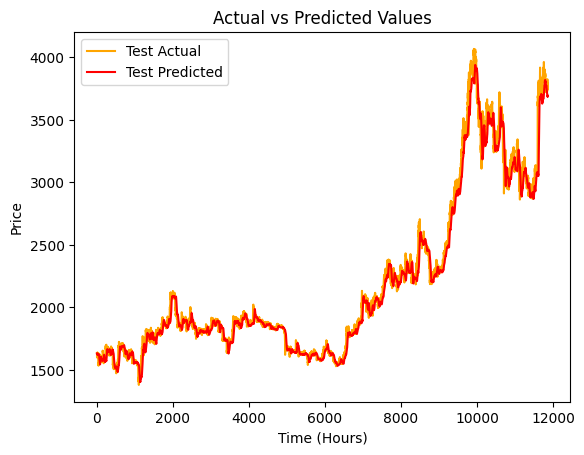

MSE: 7228.769983787158
MAE: 52.98519879234734
MAPE: 2.217008010406089


In [5]:
#model = load_model("/kaggle/working/Predict_24hr.h5")

test_predictions = model.predict(encoded_X_test)

# This code is here to reset the datasets when running code multple times in one session
X, y = create_sequences(scaled_data, SEQ_LENGTH)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Inverse Scale Values
y_test_partial_reshaped = y_test.reshape(-1, 1)
y_test_reshaped = np.repeat(y_test_partial_reshaped, X_train.shape[2], axis=1)
preds_reshaped = np.repeat(test_predictions, X_train.shape[2], axis=1)
y_pred = scaler.inverse_transform(preds_reshaped)[:,column_index]
y_test = scaler.inverse_transform(y_test_reshaped)[:,column_index]


# Plot Preds vs Targets
plt.plot(y_test, label='Test Actual', color='orange')
plt.plot(y_pred, label='Test Predicted', color='red')
plt.xlabel('Time (Hours)')
plt.ylabel('Price')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


# Metrics
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = MAPE(y_test, y_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

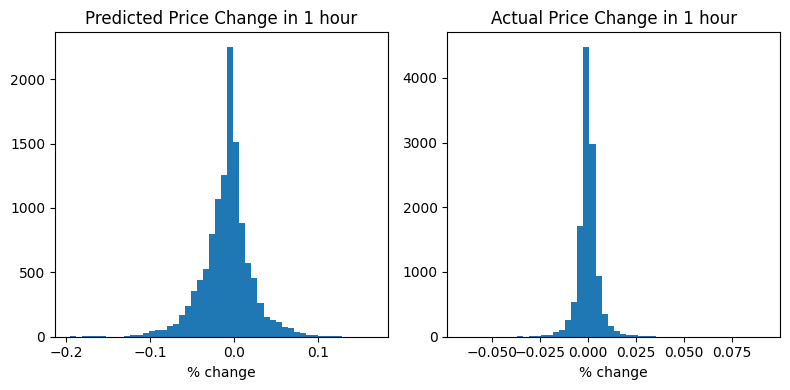

Test MAE: 0.022180613093549958


In [6]:
hours = 1

predicted_change = (y_pred[hours:] / y_test[:-hours]) - 1
actual_change = (y_test[hours:] / y_test[:-hours]) - 1

fig, ax = plt.subplots(1, 2, figsize=(8, 4)) 
ax[0].hist(predicted_change, bins=50)
ax[0].set_title(f"Predicted Price Change in {hours} hour")
ax[0].set_xlabel("% change")

ax[1].hist(actual_change, bins=50)
ax[1].set_title(f"Actual Price Change in {hours} hour")
ax[1].set_xlabel("% change")

plt.tight_layout()
plt.show()

change_mae = mean_absolute_error(actual_change, predicted_change)
print(f"Test MAE: {change_mae}")

**Identifying Performance in prediciting price direction**

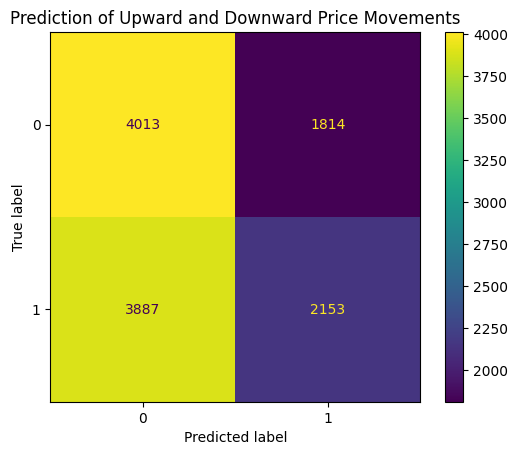

Correctly predicted upward movements percentage (Recall): 0.3564569536423841
Correctly predicted downard movements percentage (Specificity): 0.6886905783422002


In [7]:
# Transforming Preds and Targets to % difference
predicted_direction = []
actual_direction = []

# Transforming preds and targets to 1 if upwards move and 0 if downwards move
for i in range(0, len(y_pred) - 1):
    if y_pred[i + 1] >= y_test[i]:
        predicted_direction.append(1)
    else:
        predicted_direction.append(0)
        
for i in range(0, len(y_test) - 1):
    if y_test[i + 1] >= y_test[i]:
        actual_direction.append(1)
    else:
        actual_direction.append(0)

# Plotting Confusion Matrix
matrix = confusion_matrix(actual_direction, predicted_direction)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.title("Prediction of Upward and Downward Price Movements")
plt.show()


recall = matrix[(1,1)] / (matrix[(1,1)] + matrix[(1,0)])
specificity = matrix[(0,0)] / (matrix[(0,0)] + matrix[(0,1)])

print("Correctly predicted upward movements percentage (Recall):", recall)
print("Correctly predicted downard movements percentage (Specificity):", specificity)

# Trading Algorithm

In this section we create an algorithm that buys and sells ETH-USD. A buy signal is produced when our predicted prices are above a certain threshold (a given percentage higher than current price). A sell signal is produced after a certain profit level is reached or if a position is held to a specified maximum holding period. Position size and our mentioned parameter values are informed by historical estimations of VaR at various confidence levels. 

**VaR (Historical Estimation)**

In [8]:
confidence_level = 0.975
for x in range(24,97,24):
    pct_change = y_test[x:] / y_test[:-x]
    var_hist = 1 - np.percentile(pct_change, (1 - confidence_level) * 100)   
    print(f"{confidence_level * 100}% confident price will not fall more than {var_hist:.2%} in {x} hours")
print(" ")
confidence_level = 0.95
for x in range(24,97,24):
    pct_change = y_test[x:] / y_test[:-x]
    var_hist = 1 - np.percentile(pct_change, (1 - confidence_level) * 100)   
    print(f"{confidence_level * 100}% confident price will not fall more than {var_hist:.2%} in {x} hours")

97.5% confident price will not fall more than 5.34% in 24 hours
97.5% confident price will not fall more than 7.17% in 48 hours
97.5% confident price will not fall more than 8.41% in 72 hours
97.5% confident price will not fall more than 9.57% in 96 hours
 
95.0% confident price will not fall more than 4.04% in 24 hours
95.0% confident price will not fall more than 5.33% in 48 hours
95.0% confident price will not fall more than 6.38% in 72 hours
95.0% confident price will not fall more than 7.47% in 96 hours


**Trading Algorithm**

Strategy Profit: 40.36%
Buy and Hold Profit: 129.49%


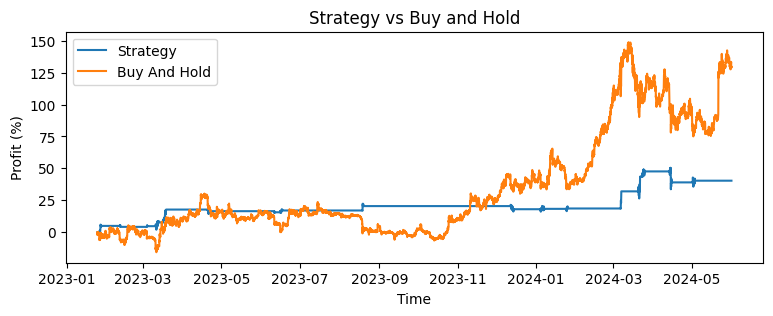

HOLD           11808
BUY               18
TIME SELL         15
PROFIT SELL        3
Name: count, dtype: int64


In [9]:
prices = y_test[:-24]
preds = y_pred[24:]
actual = y_test[24:]

initial_balance = 10000
slippage = 0.0015  # binance trading fee (0.1%) + margin loss (0.05%)
balance = initial_balance
holdings = 0
buy_price = 0
profits = []
portfolio_value = []
actions = []

position_size = 1
take_profit = 1.09
max_hold_time = 72
signal_strength = 1.04

for i in range(len(prices)):

    current_price = prices[i]
    predicted_price = preds[i]
    signal = predicted_price / current_price
    action = "HOLD"
    
    if signal > signal_strength and balance > 0:
        amount_to_invest = balance*position_size
        shares_to_buy = amount_to_invest / current_price
        transaction_cost = shares_to_buy * current_price * slippage
        actual_shares_bought = (amount_to_invest - transaction_cost) / current_price
        holdings += actual_shares_bought
        balance -= amount_to_invest
        buy_price = current_price
        action = 'BUY'   

    elif current_price > buy_price*take_profit and holdings > 0:
            transaction_cost = holdings * current_price * slippage
            balance += (holdings * current_price) - transaction_cost
            profits.append(holdings * (current_price - buy_price) - transaction_cost)
            holdings = 0
            action = "PROFIT SELL"
        
        
    if i % max_hold_time == 0 :
        if holdings > 0:
            transaction_cost = holdings * current_price * slippage
            balance += (holdings * current_price) - transaction_cost
            profits.append(holdings * (current_price - buy_price) - transaction_cost)
            holdings = 0
            action = "TIME SELL"
    

    actions.append(action)  
    portfolio_value.append(balance + (holdings * current_price))

portfolio_value = np.array(portfolio_value)
portfolio = (portfolio_value * 100 / portfolio_value[0]) - 100
strategy_profit = ((portfolio_value[-1] / initial_balance) * 100) - 100

buy_and_hold = (prices * (100 - slippage) / prices[0]) - 100
buy_and_hold_profit = ((prices[-1] / prices[0]) * 100-slippage) - 100 


print(f"Strategy Profit: {strategy_profit:.2f}%")
print(f"Buy and Hold Profit: {buy_and_hold_profit:.2f}%")

index = test.index[predict_value+10:]
plt.figure(figsize=(9, 3))
plt.plot(index, portfolio, label="Strategy")
plt.plot(index, buy_and_hold, label="Buy And Hold") 
plt.xlabel('Time')
plt.ylabel('Profit (%)')
plt.title('Strategy vs Buy and Hold')
plt.legend()
plt.show()

print(pd.Series(actions).value_counts())

# Trading Algorithm Evaluation

We evaluate our algorithm by comparing against a buy and hold strategy. We calculate the annual return, volatility, maximum drawdown and Sharpe ratio of both strategies. We estimate the risk free rate to be the average 1 year T-bill over the trading period. 

In [10]:
!pip install -q pandas pandas_datareader
import pandas_datareader.data as web
from datetime import datetime

df = web.DataReader('GS1', 'fred', datetime(2023, 1, 23),datetime(2024,6,2))
rf_annual = np.mean(df)/100
print(f"Risk Free Rate: {rf_annual}")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Risk Free Rate: 0.05081764705882353


In [11]:
PL_returns = np.diff(np.log(np.array(portfolio_value)))
market_returns = np.diff(np.log(np.array(y_test)))

def calc_max_drawdown(values):
    balances_series = pd.Series(values)
    running_max = balances_series.cummax()
    drawdown = (balances_series - running_max) / running_max
    max_drawdown = drawdown.min()
    return -max_drawdown*100

def calculate_metrics(values, rf):
    annual_return = np.mean(values)*365*24
    volatility = np.std(values)*np.sqrt(365*24)
    max_drawdown = np.max(np.maximum.accumulate(values) - values) / np.max(np.maximum.accumulate(values))
    sharpe_ratio = (annual_return - rf) / volatility
    return volatility, max_drawdown, sharpe_ratio, annual_return

trading_metrics = calculate_metrics(PL_returns,rf_annual)
buy_and_hold_metrics = calculate_metrics(market_returns,rf_annual)
trading_drawdown = calc_max_drawdown(portfolio_value)
buy_and_hold_drawdown = calc_max_drawdown(prices)

# Print metrics
print("Trading Strategy Metrics:")
print(f"Annual Return: {trading_metrics[3]*100:.2f}%")
print(f"Volatility: {trading_metrics[0]:.2f}")
print(f"Maximum Drawdown: {trading_drawdown:.2f}%")
print(f"Sharpe Ratio: {trading_metrics[2]:.2f}")

print("\nBuy and Hold Metrics:")
print(f"Annual Return: {buy_and_hold_metrics[3]*100:.2f}%")
print(f"Volatility: {buy_and_hold_metrics[0]:.2f}")
print(f"Maximum Drawdown: {buy_and_hold_drawdown:.2f}%")
print(f"Sharpe Ratio: {buy_and_hold_metrics[2]:.2f}")

Trading Strategy Metrics:
Annual Return: 25.08%
Volatility: 0.18
Maximum Drawdown: 11.17%
Sharpe Ratio: 1.11

Buy and Hold Metrics:
Annual Return: 61.54%
Volatility: 0.52
Maximum Drawdown: 29.63%
Sharpe Ratio: 1.08
